In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
register_matplotlib_converters()
import seaborn as sns
from time import time

#Models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

In [3]:
train = pd.read_csv('train.csv')
train['Date'] = pd.to_datetime(train['Date'])
train.head()
features = pd.read_csv('features.csv')
features['Date'] = pd.to_datetime(features['Date'])

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


##### Preprocessing Features
- There are some missing values for Unemployment & CPI

In [3]:
def create_features(df, label = None):
    df['Month'] = df['Date'].dt.month
    df['WeekofYear'] = df['Date'].dt.weekofyear
    df['Year'] = df['Date'].dt.year
    
    return df

In [4]:
features = create_features(features)

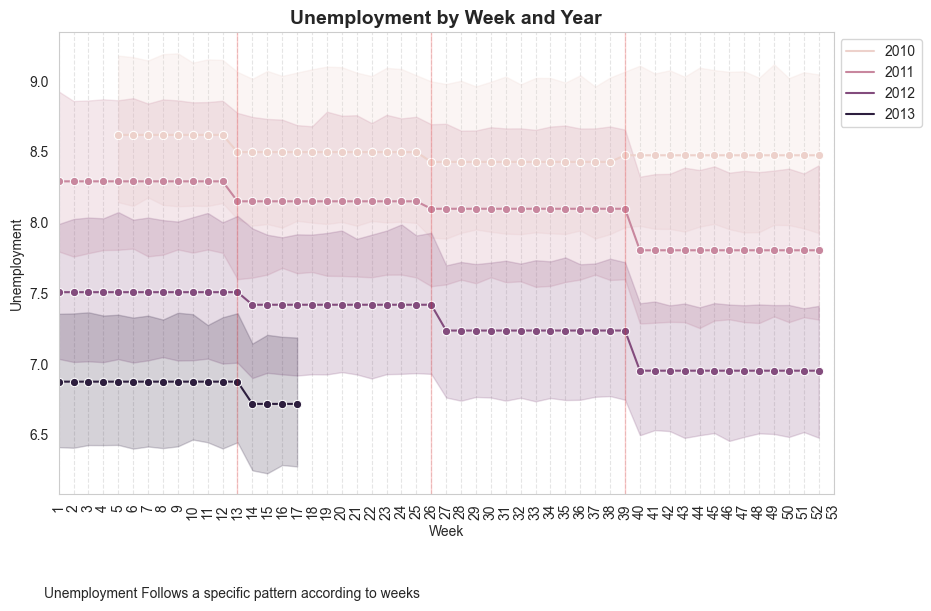

In [5]:
from matplotlib.ticker import MultipleLocator
sns.set_style("whitegrid")


# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(data=features, x='WeekofYear', y='Unemployment', hue='Year', marker='o')

plt.title('Unemployment by Week and Year', weight='bold', fontsize=14)
plt.xlabel('Week')
plt.ylabel('Unemployment')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax = plt.gca()  # Get the current Axes instance on the current figure
ax.grid(False)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 53)
plt.xticks(rotation=90)

ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.2)


plt.annotate('Unemployment Follows a specific pattern according to weeks', xy=(0, -0.2), xycoords=('data', 'axes fraction'), 
             textcoords='offset points', va='top')

for x in [13, 26, 39]:
    plt.axvline(x= x, color='red', linewidth=1, alpha = 0.2)


plt.show()

- Assume same pattern will follow for 2013
- Compute mean value of WoW drop by Store

Assums from week 18 ~ 26 Unemployment trend will the same an d from 27 ~ 39 wow computed

In [6]:
major_wks_2011 = features[(features['WeekofYear'].isin([25,26]))&(features['Year'] == 2011)].loc[:,['WeekofYear', 'Unemployment', 'Year', 'Store']]

In [7]:
major_wks_2012 = features[(features['WeekofYear'].isin([26,27]))&(features['Year'] == 2012)].loc[:,['WeekofYear', 'Unemployment', 'Year', 'Store']]

Get the Store WoW ddd

In [8]:
major_wks_2011

,WeekofYear,Unemployment,Year,Store
72,25,7.682,2011,1
73,26,7.962,2011,1
254,25,7.931,2011,2
255,26,7.852,2011,2
436,25,7.574,2011,3
...,...,...,...,...
7717,26,10.641,2011,43
7898,25,6.906,2011,44
7899,26,6.560,2011,44
8080,25,8.521,2011,45


In [9]:
major_wks_2012

,WeekofYear,Unemployment,Year,Store
125,26,7.143,2012,1
126,27,6.908,2012,1
307,26,6.891,2012,2
308,27,6.565,2012,2
489,26,6.664,2012,3
...,...,...,...,...
7770,27,9.285,2012,43
7951,26,5.621,2012,44
7952,27,5.407,2012,44
8133,26,8.567,2012,45


In [10]:
major_wks_2011 = major_wks_2011.reset_index(drop=True).drop_duplicates(subset=['WeekofYear', 'Store'])

In [11]:
major_wks_2011['WoW'] = major_wks_2011.groupby('Store')['Unemployment'].shift(1)
major_wks_2011['WoW'] = (major_wks_2011['Unemployment'] - major_wks_2011['WoW']) / major_wks_2011['WoW']


In [12]:
major_wks_2011.dropna(inplace=True)

In [13]:
major_wks_2011

,WeekofYear,Unemployment,Year,Store,WoW
1,26,7.962,2011,1,0.036449
3,26,7.852,2011,2,-0.009961
5,26,7.567,2011,3,-0.000924
7,26,5.644,2011,4,-0.050790
9,26,6.529,2011,5,0.006164
11,26,6.925,2011,6,0.010212
13,26,8.622,2011,7,0.003141
15,26,6.425,2011,8,0.020327
17,26,6.404,2011,9,0.003762
19,26,8.257,2011,10,-0.027902


In [14]:
major_wks_2012 = major_wks_2012.reset_index(drop=True).drop_duplicates(subset=['WeekofYear', 'Store'])
major_wks_2012['WoW'] = major_wks_2012.groupby('Store')['Unemployment'].shift(1)
major_wks_2012['WoW'] = (major_wks_2012['Unemployment'] - major_wks_2012['WoW']) / major_wks_2012['WoW']

In [15]:
major_wks_2012.dropna(inplace=True)

In [16]:
major_wks_2012

,WeekofYear,Unemployment,Year,Store,WoW
1,27,6.908,2012,1,-0.032899
3,27,6.565,2012,2,-0.047308
5,27,6.334,2012,3,-0.049520
7,27,4.077,2012,4,-0.053621
9,27,5.603,2012,5,-0.034132
11,27,5.668,2012,6,-0.049631
13,27,7.872,2012,7,-0.026947
15,27,5.401,2012,8,-0.048952
17,27,5.277,2012,9,-0.047301
19,27,7.170,2012,10,-0.028719


In [17]:
majorwks_consol = pd.concat([major_wks_2011, major_wks_2012], axis = 0)

In [18]:
majorwks_unemployment = pd.DataFrame(majorwks_consol.groupby(['Store'])['WoW'].mean())

In [19]:
majorwks_unemployment

,WoW
Store,
1,0.001775
2,-0.028634
3,-0.025222
4,-0.052206
5,-0.013984
6,-0.019710
7,-0.011903
8,-0.014313
9,-0.021770


In [20]:
quarterly_unemployment_q2 = features[(features['WeekofYear'].isin([17]))&(features['Year'] == 2013)].loc[:,['Unemployment', 'Store']]

In [21]:
features = pd.merge(features, quarterly_unemployment_q2, on = ['Store'], how = 'left', suffixes=('', '_from_df2'))

Fillna for different periods

In [22]:
criteria = features['WeekofYear'].between(18,26)&(features['Year'] == 2013)

In [23]:
features.loc[criteria, 'Unemployment'] = features.loc[criteria, 'Unemployment'].fillna(features['Unemployment_from_df2'])

In [24]:
features.drop(columns= ['Unemployment_from_df2'], inplace=True)

In [25]:
features.loc[features['Year'] == 2013,'WeekofYear'].max()

30

In [26]:
features = pd.merge(features, quarterly_unemployment_q2, on = ['Store'], how = 'left', suffixes=('', '_from_df2'))

In [27]:
features = pd.merge(features, majorwks_unemployment, on = ['Store'], how = 'left')

In [28]:
features['Q3_Unempl'] = round(features['Unemployment_from_df2'] * (1 + features['WoW']), 3)

In [29]:
criteria = features['WeekofYear'].between(27,30)&(features['Year'] == 2013)

features.loc[criteria, 'Unemployment'] = features.loc[criteria, 'Unemployment'].fillna(features['Q3_Unempl'])

In [30]:
features.drop(columns=['Unemployment_from_df2','WoW','Q3_Unempl'], inplace=True)

In [31]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,WeekofYear,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,3,9,2010


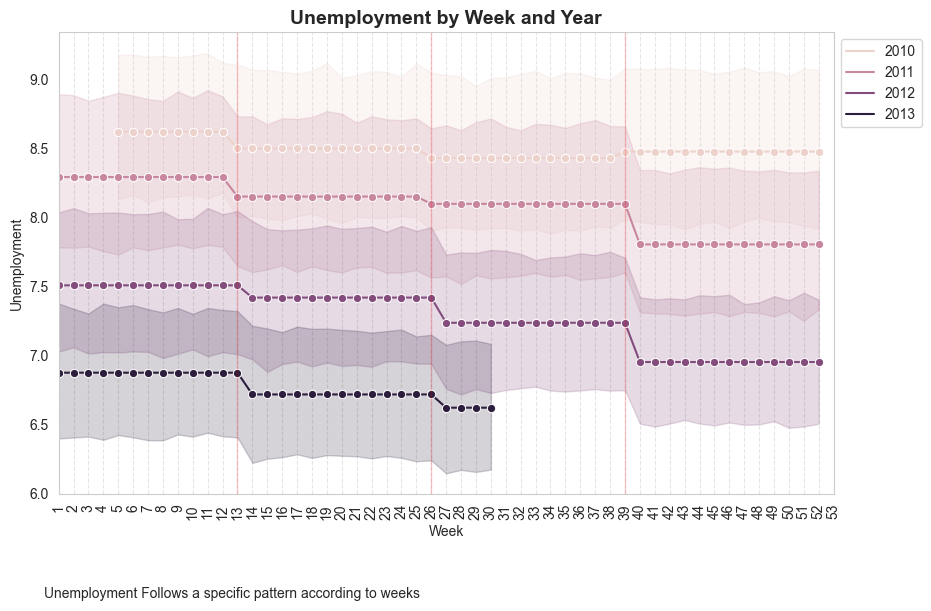

In [32]:
from matplotlib.ticker import MultipleLocator
sns.set_style("whitegrid")


# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(data=features, x='WeekofYear', y='Unemployment', hue='Year', marker='o')

plt.title('Unemployment by Week and Year', weight='bold', fontsize=14)
plt.xlabel('Week')
plt.ylabel('Unemployment')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax = plt.gca()  # Get the current Axes instance on the current figure
ax.grid(False)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 53)
plt.xticks(rotation=90)

ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.2)


plt.annotate('Unemployment Follows a specific pattern according to weeks', xy=(0, -0.2), xycoords=('data', 'axes fraction'), 
             textcoords='offset points', va='top')

for x in [13, 26, 39]:
    plt.axvline(x= x, color='red', linewidth=1, alpha = 0.2)


plt.show()

CPI Preprocessing

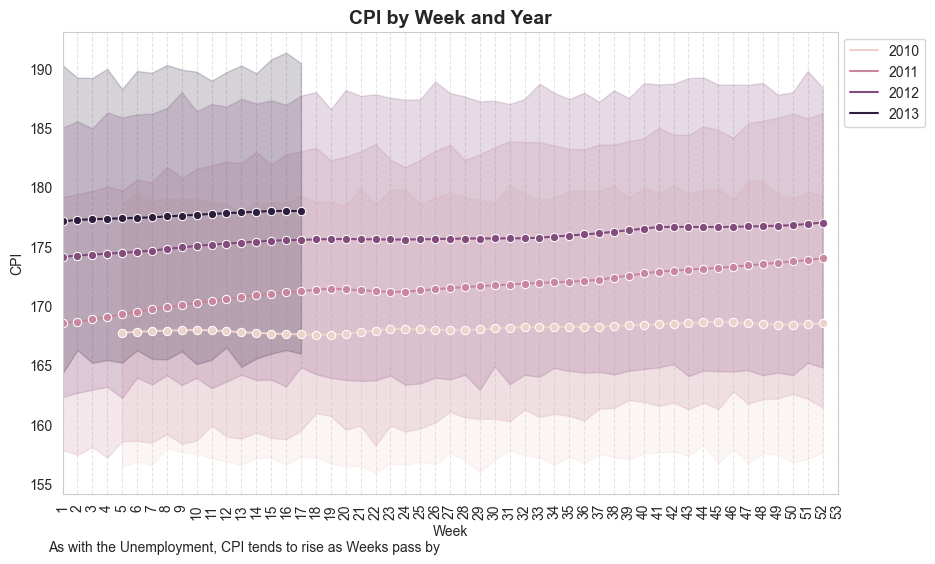

In [33]:
from matplotlib.ticker import MultipleLocator
sns.set_style("whitegrid")


# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(data=features, x='WeekofYear', y='CPI', hue='Year', marker='o')

plt.title('CPI by Week and Year', weight='bold', fontsize=14)
plt.xlabel('Week')
plt.ylabel('CPI')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax = plt.gca()  # Get the current Axes instance on the current figure
ax.grid(False)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 53)
plt.xticks(rotation=90)

ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.2)


plt.annotate('As with the Unemployment, CPI tends to rise as Weeks pass by', xy=(0, -0.1), xycoords=('data', 'axes fraction'), 
             textcoords='offset points', va='top')

plt.show()

Assume CPI will follow moving average pattern

In [34]:
# Function to apply the rolling mean to fill NA
def fill_with_rolling_mean(group):
    values = group['CPI'].copy()  
    for i in range(len(values)):
        if pd.isna(values.iat[i]):  # Check if the current 'Value' is NA
            # Calculate the rolling mean up to the current row, excluding it
            values.iat[i] = values.iloc[max(0, i-4):i].mean()
    return values

In [35]:
features['Value'] = features.groupby('Store').apply(fill_with_rolling_mean).reset_index(level=0, drop=True)


In [36]:
criteria = features['WeekofYear'].between(18,30)&(features['Year'] == 2013)
features.loc[criteria, 'CPI'] = features.loc[criteria, 'CPI'].fillna(features['Value'])

In [37]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,WeekofYear,Year,Value
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,5,2010,211.096358
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,2,6,2010,211.242170
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,2,7,2010,211.289143
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,2,8,2010,211.319643
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,3,9,2010,211.350143


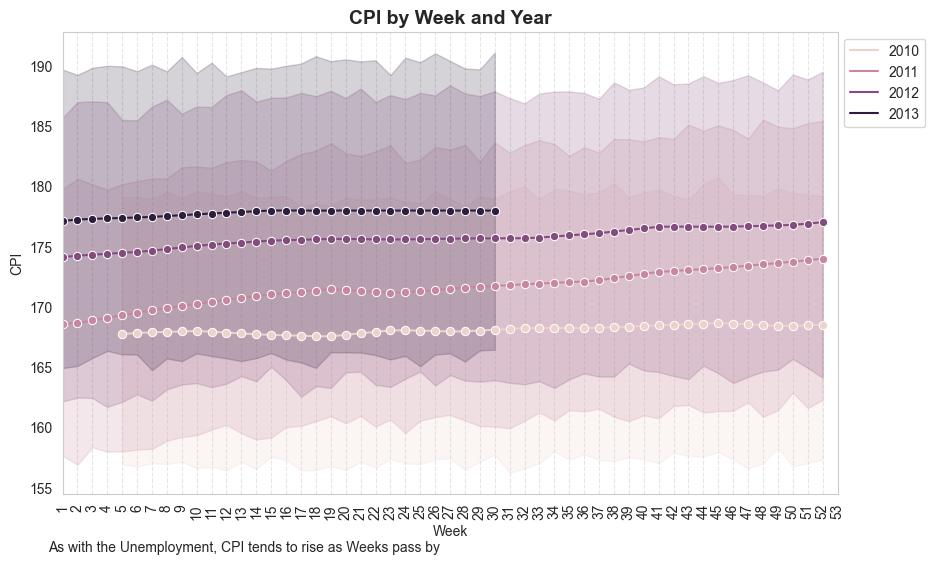

In [40]:
from matplotlib.ticker import MultipleLocator
sns.set_style("whitegrid")


# Create the line graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(data=features, x='WeekofYear', y='CPI', hue='Year', marker='o')

plt.title('CPI by Week and Year', weight='bold', fontsize=14)
plt.xlabel('Week')
plt.ylabel('CPI')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax = plt.gca()  # Get the current Axes instance on the current figure
ax.grid(False)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlim(1, 53)
plt.xticks(rotation=90)

ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.2)


plt.annotate('As with the Unemployment, CPI tends to rise as Weeks pass by', xy=(0, -0.1), xycoords=('data', 'axes fraction'), 
             textcoords='offset points', va='top')

plt.show()

In [41]:
stores = pd.read_csv('stores.csv')

In [42]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [43]:
train = pd.merge(train, features, on = ['Store', 'Date'], how = 'left')
train = pd.merge(train, stores, on = ['Store'], how = 'left')


test = pd.read_csv('test.csv')
test['Date'] = pd.to_datetime(test['Date'])
test = pd.merge(test, features, on = ['Store', 'Date'], how = 'left')
test = pd.merge(test, stores, on = ['Store'], how = 'left')

In [44]:
null_counts = train.isnull().sum(axis =0)
nulldf = pd.DataFrame(null_counts[null_counts > 0], columns = ['null_value'])
nulldf.head()

,null_value
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479
MarkDown4,286603
MarkDown5,270138


In [45]:
train.fillna(0, inplace=True)

Test NA

In [46]:
null_counts = test.isnull().sum(axis =0)
nulldf = pd.DataFrame(null_counts[null_counts > 0], columns = ['null_value'])
nulldf['ratio'] = nulldf['null_value'] / test.shape[0]
nulldf

,null_value,ratio
MarkDown1,149,0.001295
MarkDown2,28627,0.248792
MarkDown3,9829,0.085422
MarkDown4,12888,0.112007


Markdown FillNA as 0

In [47]:
test[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4']] = test[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4']].fillna(0)

In [48]:

train = create_features(train)
test = create_features(test)


In [49]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,IsHoliday_y,Month,WeekofYear,Year,Value,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,False,2,5,2010,211.096358,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,True,2,6,2010,211.242170,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,False,2,7,2010,211.289143,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,False,2,8,2010,211.319643,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,False,3,9,2010,211.350143,A,151315


In [50]:
train.drop(columns=['IsHoliday_y'], inplace=True)
train.rename(columns = {'IsHoliday_x': 'IsHoliday'}, inplace=True)

test.drop(columns=['IsHoliday_y'], inplace=True)
test.rename(columns = {'IsHoliday_x': 'IsHoliday'}, inplace=True)


isHolidayMap = {False:0, True:1}
storeType = {'A':0, 'B':1, 'C':2}

train['IsHoliday'] = train['IsHoliday'].map(isHolidayMap)
train['Type'] = train['Type'].map(storeType)

test['IsHoliday'] = test['IsHoliday'].map(isHolidayMap)
test['Type'] = test['Type'].map(storeType)

In [51]:
train.drop(columns='Value', inplace=True)
test.drop(columns='Value', inplace=True)

In [52]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,WeekofYear,Year,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2,5,2010,0,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2,6,2010,0,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2,7,2010,0,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2,8,2010,0,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,3,9,2010,0,151315


In [53]:
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,WeekofYear,Year,Type,Size
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,11,44,2012,0,151315
1,1,1,2012-11-09,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,11,45,2012,0,151315
2,1,1,2012-11-16,0,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,11,46,2012,0,151315
3,1,1,2012-11-23,1,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,11,47,2012,0,151315
4,1,1,2012-11-30,0,52.34,3.207,2460.03,0.00,3838.35,150.57,6966.34,223.610984,6.573,11,48,2012,0,151315


In [54]:
train['Days_to_Christmas'] = (pd.to_datetime(train["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(train["Date"], format="%Y-%m-%d")).dt.days.astype(int)
train['Days_to_Thansksgiving'] = (pd.to_datetime(train["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(train["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [55]:
test['Days_to_Christmas'] = (pd.to_datetime(test["Year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(test["Date"], format="%Y-%m-%d")).dt.days.astype(int)
test['Days_to_Thansksgiving'] = (pd.to_datetime(test["Year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(test["Date"], format="%Y-%m-%d")).dt.days.astype(int)

In [56]:
train['SuperBowlWeek'] = train['WeekofYear'].apply(lambda x: 1 if x == 6 else 0)
train['LaborDay'] = train['WeekofYear'].apply(lambda x: 1 if x == 36 else 0)
train['Tranksgiving'] = train['WeekofYear'].apply(lambda x: 1 if x == 47 else 0)
train['Christmas'] = train['WeekofYear'].apply(lambda x: 1 if x == 52 else 0)

In [57]:
test['SuperBowlWeek'] = test['WeekofYear'].apply(lambda x: 1 if x == 6 else 0)
test['LaborDay'] = test['WeekofYear'].apply(lambda x: 1 if x == 36 else 0)
test['Tranksgiving'] = test['WeekofYear'].apply(lambda x: 1 if x == 47 else 0)
test['Christmas'] = test['WeekofYear'].apply(lambda x: 1 if x == 52 else 0)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import GridSearchCV

In [59]:
X = train.drop('Weekly_Sales', axis = 1)
Y = train['Weekly_Sales']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=2)

In [78]:
params_grid = {
    'learning_rate':[0.1, 0.01],
    'n_estimators' : [100, 200, 500],
    'max_depth' : [3,5,6],
    'subsample' : [0.8, 1.0],
    'colsample_bytree':[0.8, 1.0]
}

In [79]:
reg = xgb.XGBRegressor()

In [80]:
grid_search = GridSearchCV(estimator=reg, param_grid=params_grid, cv=5, n_jobs=-1)

In [61]:
X_train['Date'] = X_train['Date'] = X_train['Date'].apply(lambda x: x.toordinal())

In [62]:
X_test['Date'] = X_test['Date'] = X_test['Date'].apply(lambda x: x.toordinal())

In [84]:
grid_search.fit(X_train, y_train)  # X_train and y_train should be your training data

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 6],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 1.0]})

In [86]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}
Best score found:  0.9536706369708222


In [63]:
best_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [64]:
model = xgb.XGBRegressor(colsample_bytree=best_params['colsample_bytree'],
                         learning_rate=best_params['learning_rate'],
                         max_depth=best_params['max_depth'],
                         n_estimators=best_params['n_estimators'],
                         subsample=best_params['subsample'])

In [66]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [67]:
train_prediction = model.predict(X_train)

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [71]:
mae = mean_absolute_error(y_train, train_prediction)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_train, train_prediction)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_train, train_prediction, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R^2 Score
r2 = r2_score(y_train, train_prediction)
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 2637.391960949254
Mean Squared Error (MSE): 19785410.640892405
Root Mean Squared Error (RMSE): 4448.079432844293
R-squared (R²): 0.9616765187948446


In [92]:
best_xgboost = grid_search.best_estimator_
test_prediction = best_xgboost.predict(X_test)

In [72]:
test_prediction = model.predict(X_test)

In [73]:
mae = mean_absolute_error(y_test, test_prediction)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate MSE
mse = mean_squared_error(y_test, test_prediction)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, test_prediction, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R^2 Score
r2 = r2_score(y_test, test_prediction)
print(f'R-squared (R²): {r2}')

Mean Absolute Error (MAE): 2737.9613067910204
Mean Squared Error (MSE): 23292790.065640606
Root Mean Squared Error (RMSE): 4826.260463924487
R-squared (R²): 0.9547153707447793


In [94]:
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,WeekofYear,Year,Type,Size,Days_to_Christmas,Days_to_Thansksgiving,SuperBowlWeek,LaborDay,Tranksgiving,Christmas
0,1,1,2012-11-02,0,55.32,3.386,6766.44,5147.70,50.82,3639.90,...,44,2012,0,151315,52,22,0,0,0,0
1,1,1,2012-11-09,0,61.24,3.314,11421.32,3370.89,40.28,4646.79,...,45,2012,0,151315,45,15,0,0,0,0
2,1,1,2012-11-16,0,52.92,3.252,9696.28,292.10,103.78,1133.15,...,46,2012,0,151315,38,8,0,0,0,0
3,1,1,2012-11-23,1,56.23,3.211,883.59,4.17,74910.32,209.91,...,47,2012,0,151315,31,1,0,0,1,0
4,1,1,2012-11-30,0,52.34,3.207,2460.03,0.00,3838.35,150.57,...,48,2012,0,151315,24,-6,0,0,0,0


Random Forest Regression

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [96]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [100]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [101]:
rf = RandomForestRegressor()

In [102]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [103]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 1.9min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 3.5min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 3.5min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time= 3.5min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 4.8min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 5.3min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time= 5.3min
[CV] END bootstrap=True, max_depth=10, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 4.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 4.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 7.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 7.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 4.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 7.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 9.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=12.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
